In [29]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.cm as cm
import math
import random
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization,  GlobalAveragePooling2D
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # check the folders from main directory. If there are another files, ignore them
        if pathlib.Path(foldpath).suffix != '':
            continue

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # check if there are another folders
            if pathlib.Path(foldpath).suffix == '':
                # check unneeded masks
                if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                    continue

                else:
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        filepaths.append(ipath)
                        labels.append(fold)

            else:            
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [8]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''

    # Giảm dữ liệu trong dataframe  
    def reduce_dataframe(df):  
        return df.sample(frac=0.7).reset_index(drop=True)  

    train_df = reduce_dataframe(train_df)  
    valid_df = reduce_dataframe(valid_df)  
    test_df = reduce_dataframe(test_df)  

    # Các tham số mô hình  
    img_size = (224, 224)  
    channels = 3  # Either BGR or Grayscale  
    color = 'rgb'  

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [4]:
# Display data sample
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = None
        self.initial_weights = None

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate)) # get the initial learning rate and save it
        
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    # tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr) # set the learning rate in the optimizer
                    self.model.optimizer.learning_rate.assign(lr)
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    # tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr) # set the learning rate in the optimizer
                    self.model.optimizer.learning_rate.assign(lr)
                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

In [6]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [9]:
data_dir = 'C:/Users/ACER/OneDrive/Desktop/AI in Healthcare/Covid19/COVID-19_Radiography_Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 32
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 11852 validated image filenames belonging to 4 classes.
Found 1481 validated image filenames belonging to 4 classes.
Found 1482 validated image filenames belonging to 4 classes.


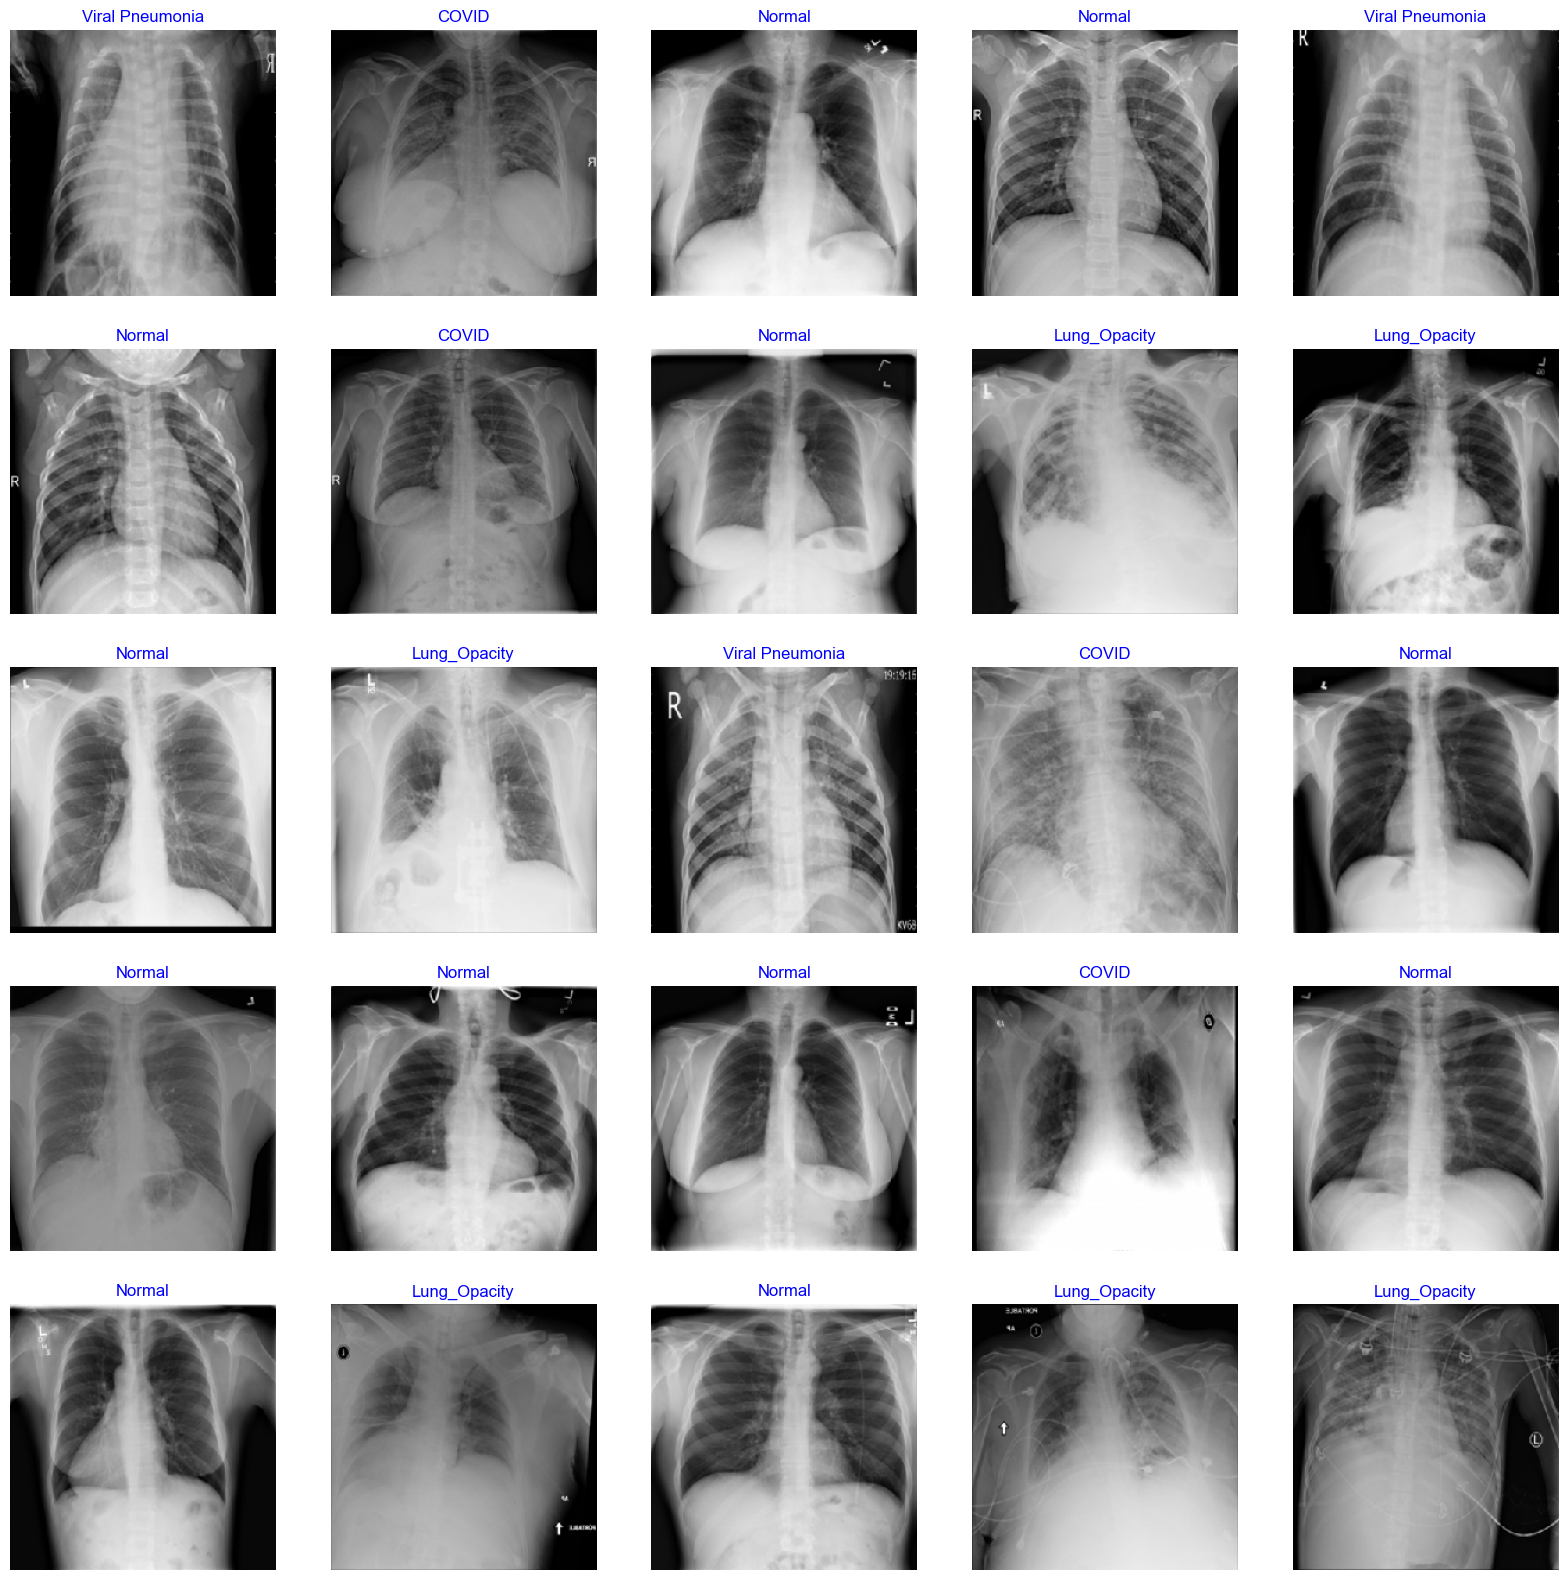

In [10]:
show_images(train_gen)

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
base_model = tf.keras.applications.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

base_model.summary()

Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [12]:
x = base_model.output
x = Flatten()(x) 
# x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,789,683 (41.16 MB)

 Trainable params: 10,702,380 (40.83 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [13]:
batch_size = 16   # set batch size for training
epochs = 50   # number of all epochs in training
patience = 10   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

In [14]:
print(len(train_gen))
print(train_gen.image_shape)
print(train_gen.batch_size)
print(train_gen.samples)

371
(224, 224, 3)
32
11852


In [15]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /50     0.509   86.509   0.53148  80.689   0.00100  0.00100  accuracy     0.00   2378.57 
 2 /50     0.198   93.208   0.21553  92.573   0.00100  0.00100  val_loss    59.45   2322.99 
 3 /50     0.173   94.077   0.18878  93.248   0.00100  0.00100  val_loss    12.41   2350.05 
 4 /50     0.139   95.267   0.31390  89.332   0.00100  0.00100  val_loss    -66.27  2348.40 
 5 /50     0.124   95.722   0.20191  93.045   0.00100  0.00100  val_loss    -6.95   2348.69 
enter H to halt training or an integer for number of epochs to run then ask again
 training will continue until epoch 15
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /50     0.140   95.148   0.20290  92.370   0.00100  0.00100  val_loss    -7.48   2368.85 
 7 /50     0.124   95.714   0.15312  94.261   0.00100  0.00100  val_loss    18.89

In [16]:
# Lưu history
with open('train_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Lịch sử huấn luyện đã được lưu.")

Lịch sử huấn luyện đã được lưu.


In [21]:
# Load lại model nếu restart kernel
model = load_model('C:/Users/ACER/OneDrive/Desktop/AI in Healthcare/Covid19/functional_5-Covid-19-95.94.h5')
print("Model loaded successfully!")

Model loaded successfully!


In [36]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 32,194,445 (122.81 MB)

 Trainable params: 10,702,380 (40.83 MB)

 Non-trainable params: 87,303 (341.03 KB)

 Optimizer params: 21,404,762 (81.65 MB)

In [ ]:
# Load lại history nếu restart kernel
with open('train_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

print("Training history loaded successfully!")


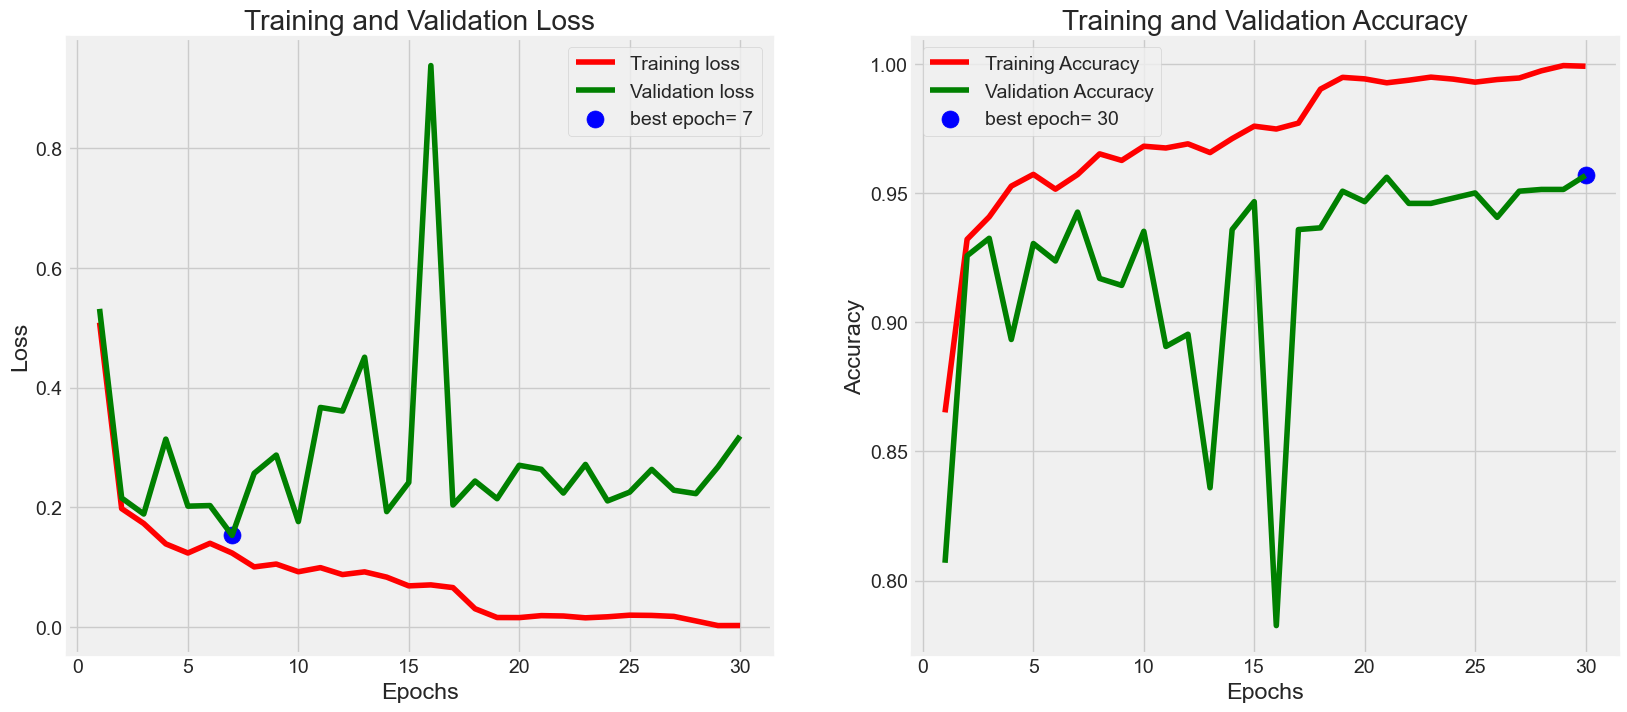

In [18]:
plot_training(history)

In [19]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9784 - loss: 0.0721
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9343 - loss: 0.1506
29/29 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9433 - loss: 0.1626
Train Loss:  0.06895969808101654
Train Accuracy:  0.9762930870056152
--------------------
Validation Loss:  0.1373722404241562
Validation Accuracy:  0.9461206793785095
--------------------
Test Loss:  0.15799255669116974
Test Accuracy:  0.9514170289039612


In [20]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

19/19 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step
[1 2 2 ... 2 0 3]


Confusion Matrix, Without Normalization
[[233   5   6   0]
 [  0 403  29   0]
 [  2  25 686   1]
 [  0   0   4  88]]
                 precision    recall  f1-score   support

          COVID       0.99      0.95      0.97       244
   Lung_Opacity       0.93      0.93      0.93       432
         Normal       0.95      0.96      0.95       714
Viral Pneumonia       0.99      0.96      0.97        92

       accuracy                           0.95      1482
      macro avg       0.96      0.95      0.96      1482
   weighted avg       0.95      0.95      0.95      1482



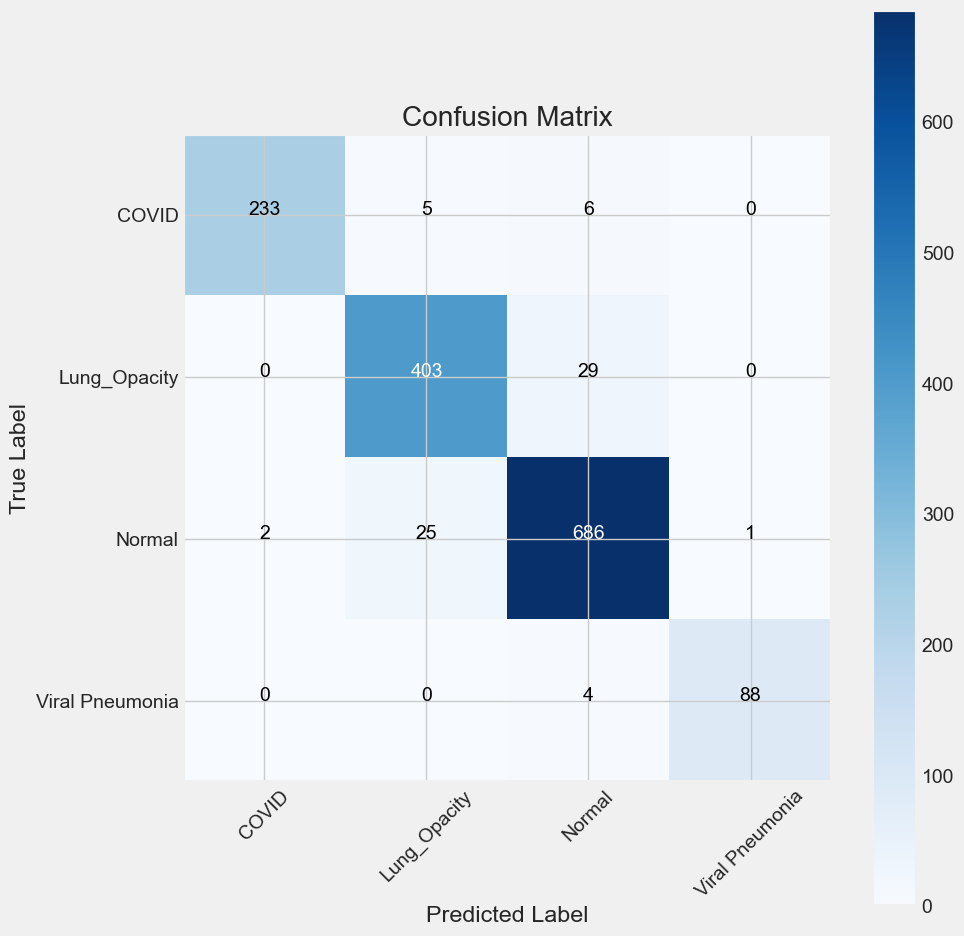

In [21]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [22]:
# model_name = model.input_names[0][:-6]
model_name = model.name
subject = 'Covid-19'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}.weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as functional_1-Covid-19-95.14.h5
weights were saved as functional_1-Covid-19.weights.h5


In [23]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Covid-19-class_dict.csv


CAM, Grad-CAM, Grad-CAM++

In [24]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from scipy.ndimage import zoom
from cv2 import resize, INTER_LINEAR
import cv2 as cv

In [25]:
# Hàm tiền xử lý ảnh
def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Chuẩn hóa ảnh
    return img_array

**CAM**

In [26]:
# Hàm tạo CAM
def generate_cam(input_model, image_path, feature_layer='top_conv', H=224, W=224):
    # Tiền xử lý ảnh
    img_array = get_img_array(image_path, size=(H, W))

    # Dự đoán ảnh đầu vào
    pred = input_model.predict(img_array)
    cls = np.argmax(pred[0])  # Lấy lớp có xác suất cao nhất

    # Lấy trọng số từ lớp fully connected cuối cùng (lớp Dense)
    fc_weights = input_model.layers[-1].get_weights()[0]  # Trọng số của lớp đầu ra

    # Lấy output của feature map trước lớp fully connected
    feature_model = tf.keras.Model(inputs=input_model.input, 
                                   outputs=input_model.get_layer(feature_layer).output)
    feature_map = feature_model.predict(img_array)[0]

    # Tạo CAM bằng cách nhân feature map với trọng số lớp dự đoán
    cam = np.dot(feature_map, fc_weights[:, cls])

    # Chuẩn hóa giá trị heatmap
    cam = np.maximum(cam, 0)  # Chỉ giữ giá trị dương
    cam = cam / (np.max(cam) + 1e-5)  # Chuẩn hóa từ 0-1
    cam = cv2.resize(cam, (W, H))  # Resize để khớp kích thước ảnh gốc
    cam = np.uint8(255 * cam)  # Chuyển về dạng ảnh

    # Áp dụng colormap lên CAM
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # Lấy màu từ 0-255
    jet_heatmap = jet_colors[cam]

    # Chuyển đổi heatmap thành ảnh
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((W, H))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Tạo ảnh gốc từ img_array (rescale từ [0,1] lên [0,255])
    original_img = (img_array[0] * 255).astype(np.uint8)

    # Chồng heatmap lên ảnh gốc
    superimposed_img = jet_heatmap * 0.4 + original_img
    superimposed_img = image.array_to_img(superimposed_img)

    # Trả về ảnh gốc, ảnh CAM và ảnh chồng CAM
    return original_img, cam, superimposed_img, cls

**GRAD-CAM**

In [27]:
# Hàm tạo Grad-CAM
def generate_grad_cam(input_model, image_path, layer_name='top_conv', H=224, W=224):
    # Tiền xử lý ảnh
    img_array = get_img_array(image_path, size=(H, W))

    # Giải nén output của mô hình thành danh sách phẳng
    model_outputs = input_model.output if isinstance(input_model.output, list) else [input_model.output]

    # Tạo mô hình Grad-CAM với các đầu ra đúng định dạng
    grad_model = tf.keras.Model(
        inputs=input_model.input,
        outputs=[input_model.get_layer(layer_name).output] + model_outputs
    )


    # Tính gradient của lớp được dự đoán so với đầu ra lớp tích chập
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        cls = tf.argmax(predictions[0])  # Lấy lớp có xác suất cao nhất
        loss = predictions[:, cls]  # Giá trị loss liên quan đến lớp này

    # Tính gradient
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Tạo heatmap bằng cách nhân trọng số gradient với feature map
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)

    # Chuẩn hóa heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-5)
    heatmap = np.uint8(255 * heatmap)

    # Resize heatmap để khớp với kích thước ảnh gốc
    heatmap = cv2.resize(heatmap, (W, H))

    # Áp dụng colormap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # Lấy màu từ 0-255
    jet_heatmap = jet_colors[heatmap]

    # Chuyển đổi heatmap về ảnh
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((W, H))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Tạo ảnh gốc từ img_array (rescale từ [0,1] lên [0,255])
    original_img = (img_array[0] * 255).astype(np.uint8)

    # Chồng heatmap lên ảnh gốc
    superimposed_img = jet_heatmap * 0.4 + original_img
    superimposed_img = image.array_to_img(superimposed_img)

    # Trả về ảnh gốc, ảnh heatmap và ảnh chồng heatmap
    return original_img, heatmap, superimposed_img, cls.numpy()

**GRAD-CAM++**

In [83]:
def generate_gradcam_plus_plus(input_model, image_path, layer_name='top_conv', H=224, W=224):
    # Đọc ảnh và tiền xử lý
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(H, W))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension

    # Tạo mô hình phụ để lấy conv_output và predictions
    conv_layer = input_model.get_layer(layer_name)
    print(f"Layer '{layer_name}' trainable: {conv_layer.trainable}")
    assert input_model.get_layer(layer_name).trainable, "Selected layer is not trainable"
    
    # Xác định đầu ra của mô hình
    if isinstance(input_model.output, list):
        model_output = input_model.output[0]  # Chọn đầu ra đầu tiên nếu có nhiều đầu ra
    else:
        model_output = input_model.output

    grad_model = tf.keras.models.Model(
        inputs=input_model.inputs,  # Truyền trực tiếp input_model.inputs
        outputs=[conv_layer.output, model_output]
    )

    # Tính toán gradient
    with tf.GradientTape(persistent=True) as tape:
        conv_output, predictions = grad_model(img_array)
        tape.watch(conv_output)
        cls = tf.argmax(predictions[0])  # Lớp có xác suất cao nhất
        # loss = predictions[:, cls] * 1000  # Nhân hệ số để khuếch đại gradient
        loss = -tf.reduce_sum(predictions * tf.math.log(predictions + 1e-8))

    # Tính gradient bậc 1
    grads = tape.gradient(loss, conv_output)
    if grads is None:
        raise ValueError("Gradient computation returned None. Check if the model is differentiable.")

    first_derivative = grads

    # Tính gradient bậc 2
    second_derivative = tape.gradient(first_derivative, conv_output)
    if second_derivative is None:
        raise ValueError("Second derivative computation returned None. Check if the model is differentiable.")

    # Tính gradient bậc 3
    third_derivative = tape.gradient(second_derivative, conv_output)
    if third_derivative is None:
        raise ValueError("Third derivative computation returned None. Check if the model is differentiable.")

    # Tính trọng số alpha
    alpha_num = second_derivative
    alpha_denom = 2.0 * second_derivative + third_derivative * conv_output
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    alphas = alpha_num / alpha_denom

    # Tính trọng số trọng số alpha * relu của gradient bậc 1
    weights = tf.reduce_sum(alphas * tf.nn.relu(first_derivative), axis=(0, 1, 2))
    conv_output = conv_output[0].numpy()
    weights = weights.numpy()

    # Tạo heatmap Grad-CAM++
    for i in range(weights.shape[-1]):
        conv_output[:, :, i] *= weights[i]
    heatmap = np.sum(conv_output, axis=-1)

    # Chuẩn hóa heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-5)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (W, H))

    # Áp dụng colormap
    jet = cv2.COLORMAP_JET
    heatmap = cv2.applyColorMap(heatmap, jet)

    # Chồng heatmap lên ảnh gốc
    superimposed_img = cv2.addWeighted(img_array[0].astype(np.uint8), 0.6, heatmap, 0.4, 0)

    del tape

    return img_array[0].astype(np.uint8), heatmap, superimposed_img, cls.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


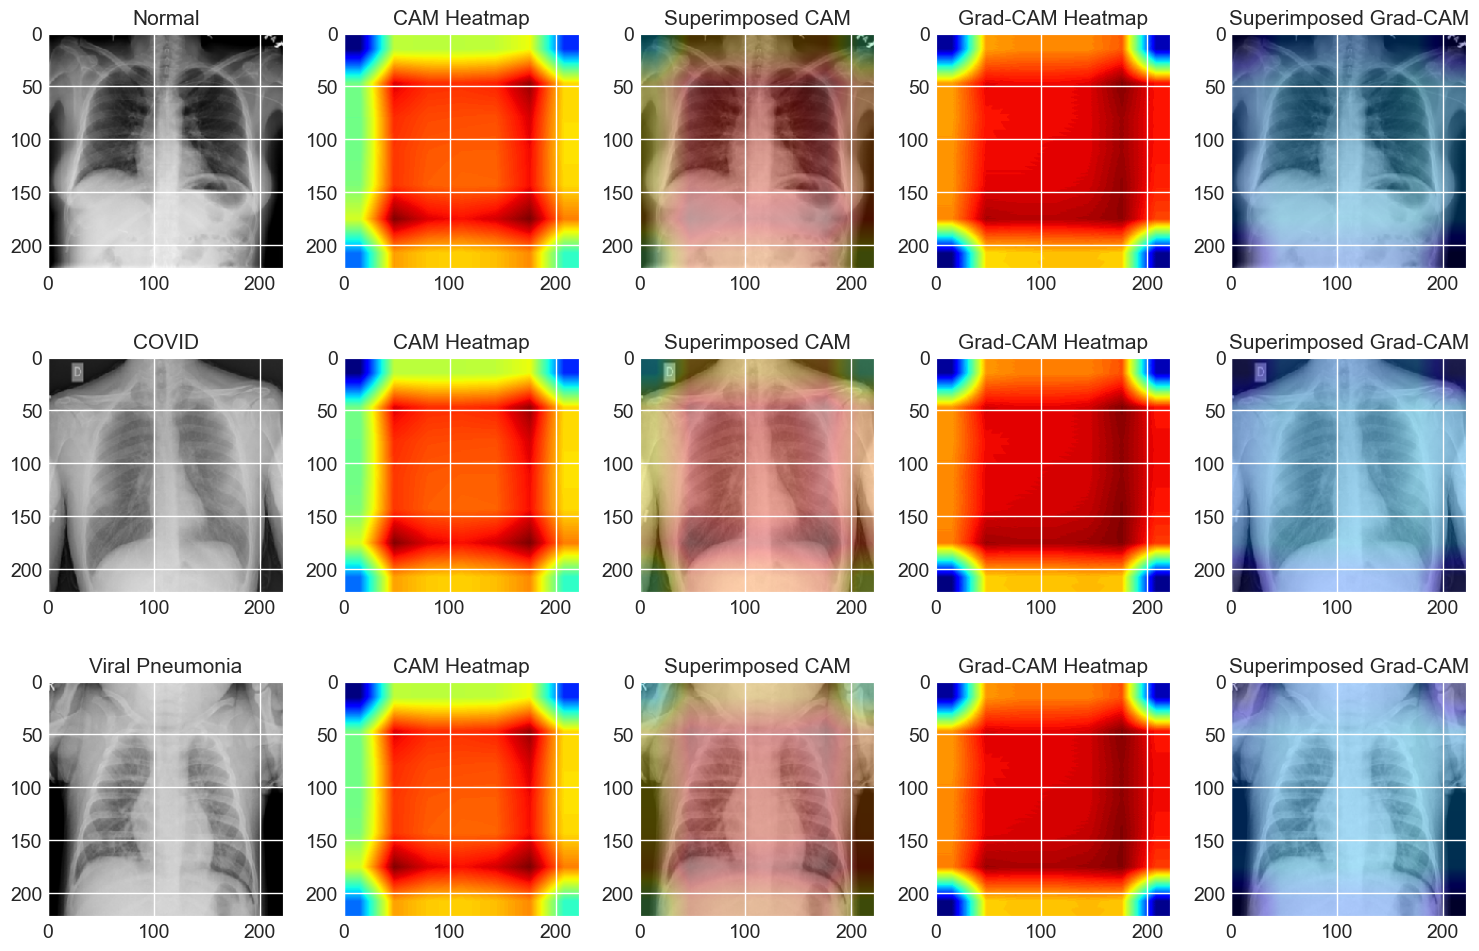

In [88]:
# Đường dẫn thư mục ảnh
base_dir = 'C:/Users/ACER/OneDrive/Desktop/AI in Healthcare/Covid19/COVID-19_Radiography_Dataset'
categories = ['Normal', 'COVID', 'Viral Pneumonia']

# Lấy danh sách file ảnh từ mỗi thư mục
image_files = {category: sorted(os.listdir(os.path.join(base_dir, category, 'images'))) for category in categories}

# Chọn một ảnh random từ mỗi thư mục
min_length = min(len(image_files[category]) for category in categories)
random_index = random.randint(0, min_length - 1)

# Lấy ảnh ở vị trí index đã chọn từ tất cả các thư mục
image_paths = [
    os.path.join(base_dir, 'Normal', 'images', image_files['Normal'][random_index]).replace('\\', '/'),
    os.path.join(base_dir, 'COVID', 'images', image_files['COVID'][random_index]).replace('\\', '/'),
    os.path.join(base_dir, 'Viral Pneumonia', 'images', image_files['Viral Pneumonia'][random_index]).replace('\\', '/')
]

# print(image_paths)

message = input('Enter 1 for CAM, 2 for Grad-CAM, 3 for both: ')

if message == '1' or message == '2':
    fig, axes = plt.subplots(3, 3, figsize=(12, 13))

    for i, (category, img_path) in enumerate(zip(categories, image_paths)):
        if message == '1':
            original_img, cam, superimposed_img, predicted_class = generate_cam(model, img_path)
        elif message == '2':
            original_img, cam, superimposed_img, predicted_class = generate_grad_cam(model, img_path)

        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(category)  # Set category as the title

        axes[i, 1].imshow(cam, cmap='jet')
        axes[i, 1].set_title('Heatmap')

        axes[i, 2].imshow(superimposed_img)
        axes[i, 2].set_title('Superimposed')

    plt.tight_layout()
    plt.show()
else:
    fig, axes = plt.subplots(len(image_paths), 5, figsize=(15, 15))

    for i, (category, img_path) in enumerate(zip(categories, image_paths)):
        # Generate CAM
        original_img, cam, superimposed_img_cam, predicted_class_cam = generate_cam(model, img_path)

        # Generate Grad-CAM
        original_img, grad_cam, superimposed_img_grad_cam, predicted_class_grad_cam = generate_grad_cam(model, img_path)

        # Display original image
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(category, fontsize=15)  # Set category as the title

        # Display CAM heatmap
        axes[i, 1].imshow(cam, cmap='jet')
        axes[i, 1].set_title('CAM Heatmap', fontsize=15)

        # Display Superimposed CAM image
        axes[i, 2].imshow(superimposed_img_cam)
        axes[i, 2].set_title('Superimposed CAM', fontsize=15)

        # Display Grad-CAM heatmap
        axes[i, 3].imshow(grad_cam, cmap='jet')
        axes[i, 3].set_title('Grad-CAM Heatmap', fontsize=15)

        # Display Superimposed Grad-CAM image
        axes[i, 4].imshow(superimposed_img_grad_cam)
        axes[i, 4].set_title('Superimposed Grad-CAM', fontsize=15)

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.6)
    plt.show()

Layer 'top_conv' trainable: True
Gradient min: -0.21613514
Gradient max: 0.37972745
Gradient mean: 0.00011994346


ValueError: Second derivative computation returned None. Check if the model is differentiable.

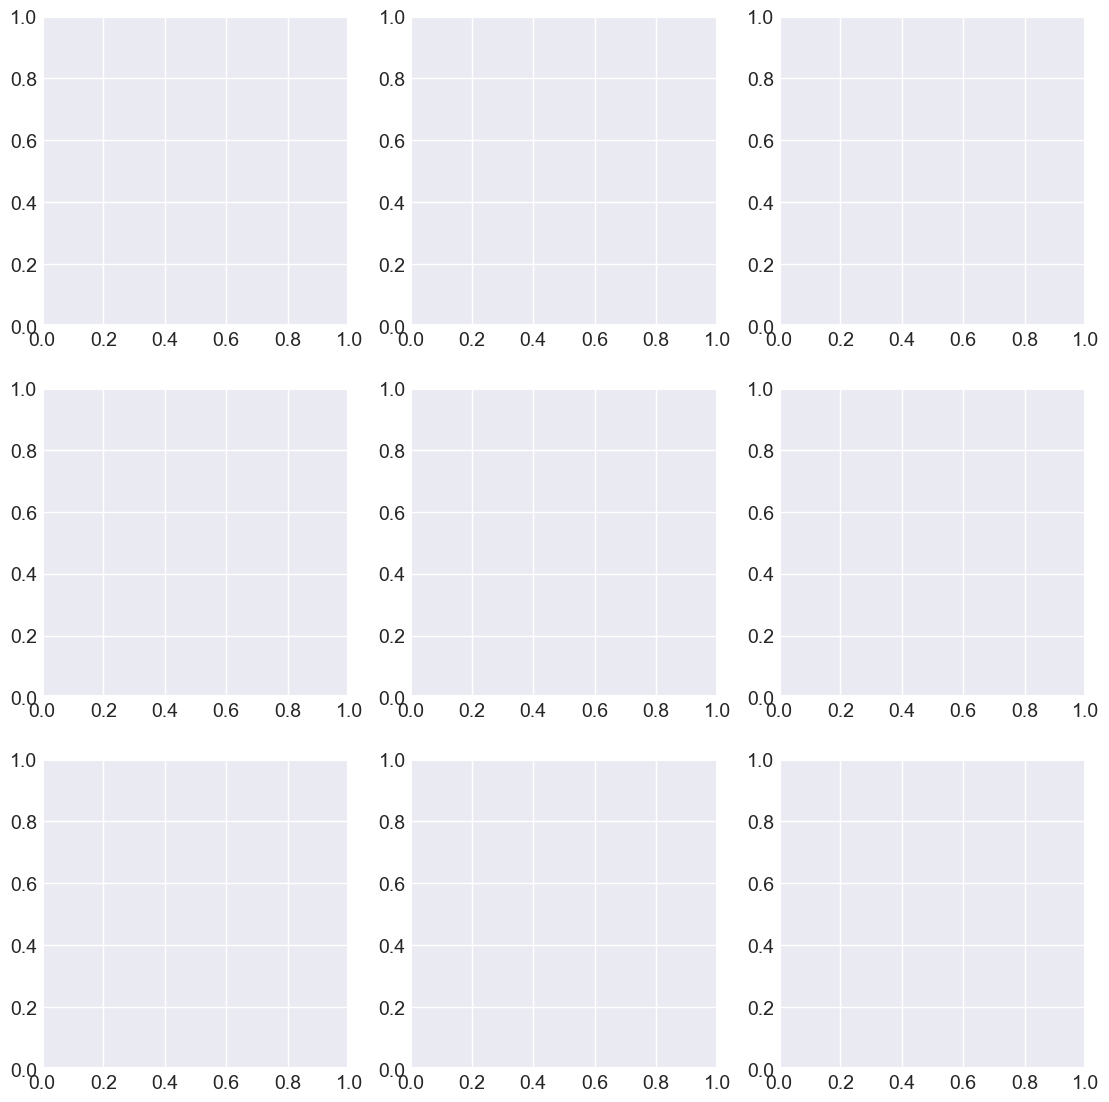

In [89]:
fig, axes = plt.subplots(3, 3, figsize=(12, 13))

for i, (category, img_path) in enumerate(zip(categories, image_paths)):
    original_img, cam, superimposed_img, predicted_class = generate_gradcam_plus_plus(model, img_path)

    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title(category)  # Set category as the title

    axes[i, 1].imshow(cam, cmap='jet')
    axes[i, 1].set_title('Heatmap')

    axes[i, 2].imshow(superimposed_img)
    axes[i, 2].set_title('Superimposed')

plt.tight_layout()
plt.show()